# Game sales prediction-Catboost

## Overview
The gaming industry is certainly one of the thriving industries of the modern age and one of those that are most influenced by the advancement in technology. With the availability of technologies like AR/VR in consumer products like gaming consoles and even smartphones, the gaming sector shows great potential. In this hackathon, you as a data scientist must use your analytical skills to predict the sales of video games depending on given factors. Given are 8 distinguishing factors that can influence the sales of a video game. Your objective as a data scientist is to build a machine learning model that can accurately predict the sales in millions of units for a given game.

## Import Libraries

In [154]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox, skew
from scipy.special import inv_boxcox
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
# Import LightGBM
from lightgbm import LGBMRegressor

from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, train_test_split
# Linear Regression Model
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_squared_log_error


## Loading Dataset

In [2]:
game_train_df = pd.read_csv('./data/Train.csv', header=0)
game_test_df = pd.read_csv('./data/Test.csv', header=0)
game_submit_df = pd.read_csv('./data/Sample_Submission.csv', header=0)

In [3]:
game_train_df.info()
print("--"*40)
game_train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3506 entries, 0 to 3505
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               3506 non-null   int64  
 1   CONSOLE          3506 non-null   object 
 2   YEAR             3506 non-null   int64  
 3   CATEGORY         3506 non-null   object 
 4   PUBLISHER        3506 non-null   object 
 5   RATING           3506 non-null   object 
 6   CRITICS_POINTS   3506 non-null   float64
 7   USER_POINTS      3506 non-null   float64
 8   SalesInMillions  3506 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 246.6+ KB
--------------------------------------------------------------------------------


,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.215050
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,1.383964
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.082671


In [4]:
game_test_df.info()
print('--'*40)
game_test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1503 non-null   int64  
 1   CONSOLE         1503 non-null   object 
 2   YEAR            1503 non-null   int64  
 3   CATEGORY        1503 non-null   object 
 4   PUBLISHER       1503 non-null   object 
 5   RATING          1503 non-null   object 
 6   CRITICS_POINTS  1503 non-null   float64
 7   USER_POINTS     1503 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 94.1+ KB
--------------------------------------------------------------------------------


,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS
0,4310,ps2,2008,action,Tecmo Koei,T,3.928571,0.482353
1,4011,psp,2007,strategy,Atari,E10+,5.538462,0.071795
2,2185,ps2,2004,shooter,Electronic Arts,T,3.034483,0.062044
3,1644,x,2006,action,Electronic Arts,E,2.913043,0.880000
4,188,3ds,2011,racing,Ubisoft,E10+,1.162162,0.183333


In [5]:
game_submit_df.head()

,SalesInMillions
0,1.497533
1,2.368795
2,2.630505
3,2.506086
4,1.970574


## Feature Engineering

In [6]:
dataset = pd.concat([game_train_df, game_test_df], keys=[0,1])
print(dataset.columns)
print(np.unique(dataset['YEAR']))
# print(dataset['CONSOLE'].unique())
# print(dataset['CATEGORY'].unique())
# print(dataset['PUBLISHER'].unique())

Index(['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions'],
      dtype='object')
[1988 1994 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]


In [7]:
num_years = lambda y: int(2020 - y)
dataset['NUM_YEARS'] = dataset['YEAR'].apply(num_years)

**Interaction features**

In [8]:
interaction1 = dataset['CONSOLE'] +"_"+ dataset['CATEGORY']
interaction2 = dataset['CONSOLE'] +"_"+ dataset['PUBLISHER']
interaction3 = dataset['PUBLISHER'] +"_"+ dataset['CATEGORY']
interaction4 = dataset['CONSOLE'] +"_"+ dataset['RATING']
dataset['CN_CA'] = interaction1
dataset['CN_PB'] = interaction2
dataset['PB_CA'] = interaction3
dataset['CN_RT'] = interaction4

In [9]:
dataset.columns

Index(['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions', 'NUM_YEARS',
       'CN_CA', 'CN_PB', 'PB_CA', 'CN_RT'],
      dtype='object')

## Preprocessing

In [10]:
print(f"Size of the dataset : {dataset.shape[0]}")
print(f"Is there any null values : {dataset.isnull().sum()}")
print(f"Categorical columns : {dataset.select_dtypes(include=['object']).columns}")

Size of the dataset : 5009
Is there any null values : ID                    0
CONSOLE               0
YEAR                  0
CATEGORY              0
PUBLISHER             0
RATING                0
CRITICS_POINTS        0
USER_POINTS           0
SalesInMillions    1503
NUM_YEARS             0
CN_CA                 0
CN_PB                 0
PB_CA                 0
CN_RT                 0
dtype: int64
Categorical columns : Index(['CONSOLE', 'CATEGORY', 'PUBLISHER', 'RATING', 'CN_CA', 'CN_PB', 'PB_CA',
       'CN_RT'],
      dtype='object')


In [11]:
y_target = np.log1p(game_train_df['SalesInMillions'])
# y_target = boxcox(game_train_df['SalesInMillions'], lmbda=0.01)
print(skew(y_target))
# pwr_transformer = PowerTransformer()
# y_train = pwr_transformer.fit_transform(game_train_df['SalesInMillions'].to_frame())

0.4294587381837518


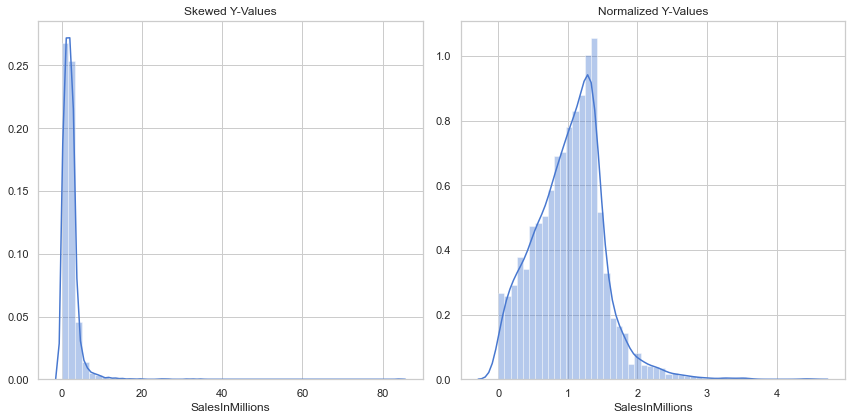

In [12]:
sns.set(style='whitegrid', palette='muted')
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.distplot(game_train_df['SalesInMillions'], kde=True, ax=axes[0])
# sns.distplot(y_train, kde=True, ax=axes[1])
sns.distplot(y_target, kde=True, ax=axes[1])
axes[0].set_title("Skewed Y-Values")
axes[1].set_title("Normalized Y-Values")
plt.tight_layout()
plt.show()

## Label Encoding

In [363]:
def prepare_label_encode(dataframe):
    try:
        # Making a copy of dataset
        data_set = dataframe.copy()
        
        # Getting the categorical columns
        cat_data = data_set.select_dtypes(include=['object'])
        
        # One-hot encoding on the category columns
        X_encode = cat_data.apply(LabelEncoder().fit_transform)
        
        # Drop the date column
        data_set.drop(cat_data.columns, inplace=True, axis=1)
        
        # Merge the data
        data_set = pd.concat([data_set, X_encode], axis=1)
        
        return data_set
    
    except Exception as e:
        print(f"Error in encoding the category data: {e}")

In [364]:
dataset_enc = prepare_label_encode(dataset)

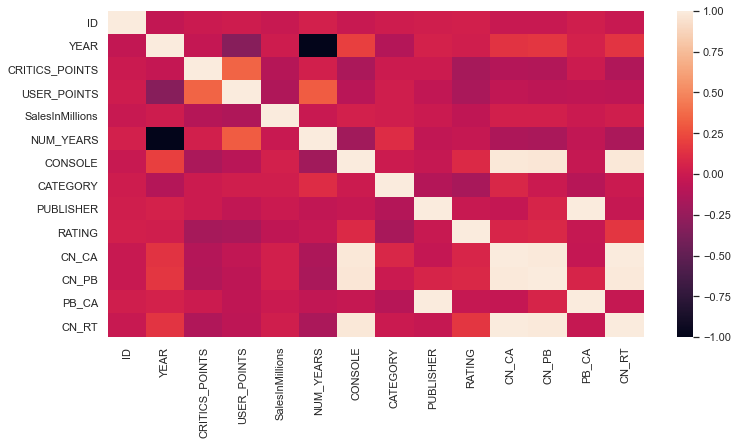

In [365]:
# Correlation between the numeric variables
corr = dataset_enc.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr)
plt.show()

In [366]:
# corr['SalesInMillions'].sort_values()
print (corr['SalesInMillions'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr['SalesInMillions'].sort_values(ascending=False)[-5:]) #last 5 values`

SalesInMillions    1.000000
CONSOLE            0.039715
CN_PB              0.034745
CN_CA              0.034740
CN_RT              0.028043
CATEGORY           0.026411
YEAR               0.015476
PB_CA             -0.004739
PUBLISHER         -0.006652
NUM_YEARS         -0.015476
ID                -0.021986
RATING            -0.058180
CRITICS_POINTS    -0.102378
USER_POINTS       -0.140307
Name: SalesInMillions, dtype: float64 

----------------------
NUM_YEARS        -0.015476
ID               -0.021986
RATING           -0.058180
CRITICS_POINTS   -0.102378
USER_POINTS      -0.140307
Name: SalesInMillions, dtype: float64


In [367]:
dataset_enc.columns

Index(['ID', 'YEAR', 'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions',
       'NUM_YEARS', 'CONSOLE', 'CATEGORY', 'PUBLISHER', 'RATING', 'CN_CA',
       'CN_PB', 'PB_CA', 'CN_RT'],
      dtype='object')

In [368]:
# Getting back the Tran and Test data
X_enc_train, X_enc_test = dataset_enc.xs(0), dataset_enc.xs(1)

## Feature Selection

In [369]:
X_enc_train.shape

(3506, 14)

In [370]:
X = X_enc_train.loc[:, X_enc_train.columns != 'SalesInMillions']
y = X_enc_train.loc[:, X_enc_train.columns == 'SalesInMillions']

In [371]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 0 to 3505
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              3506 non-null   int64  
 1   YEAR            3506 non-null   int64  
 2   CRITICS_POINTS  3506 non-null   float64
 3   USER_POINTS     3506 non-null   float64
 4   NUM_YEARS       3506 non-null   int64  
 5   CONSOLE         3506 non-null   int32  
 6   CATEGORY        3506 non-null   int32  
 7   PUBLISHER       3506 non-null   int32  
 8   RATING          3506 non-null   int32  
 9   CN_CA           3506 non-null   int32  
 10  CN_PB           3506 non-null   int32  
 11  PB_CA           3506 non-null   int32  
 12  CN_RT           3506 non-null   int32  
dtypes: float64(2), int32(8), int64(3)
memory usage: 273.9 KB


In [372]:
nCol = len(dataset.columns)
best_col = SelectKBest(f_regression, k='all').fit(X, X_enc_train['SalesInMillions'])

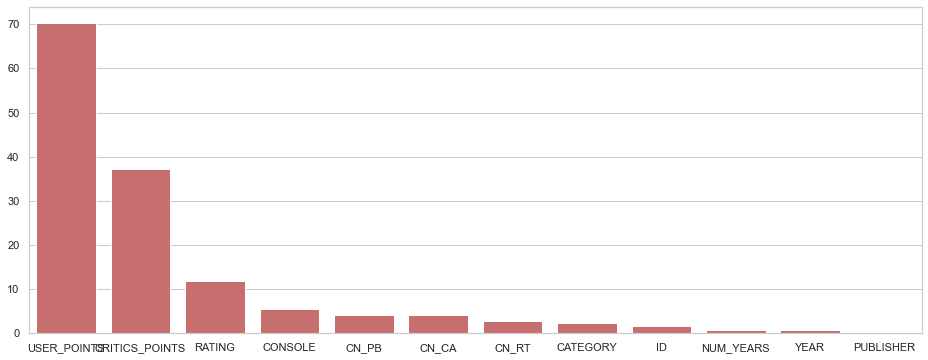

In [373]:
sns.set(style='whitegrid', palette='muted')
# Get the indices sorted by most important to least important
indices = np.argsort(best_col.scores_)[::-1]

# To get your top 10 feature names
features = []
for i in range(12):
    features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(16,6))
sns.barplot(features, best_col.scores_[indices[range(12)]], color='r')
plt.show()

In [135]:
dataset.columns

Index(['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions', 'NUM_YEARS',
       'CN_CA', 'CN_PB', 'PB_CA', 'CN_RT'],
      dtype='object')

In [374]:
# best_cols = ['CRITICS_POINTS', 'USER_POINTS', 'CONSOLE','PUBLISHER','RATING','CATEGORY','CN_CA','CN_PB','CN_RT']
# best_cols = ['CRITICS_POINTS', 'USER_POINTS','CONSOLE','NUM_YEARS','RATING']
# best_cols = ['CRITICS_POINTS', 'USER_POINTS','CN_PB','CN_RT','CN_CA','CATEGORY','CONSOLE','YEAR']

best_cols = ['CRITICS_POINTS', 'USER_POINTS','CONSOLE','NUM_YEARS','RATING','CN_PB','PB_CA','CN_RT','CN_CA','CATEGORY','ID']
# best_cols = ['CRITICS_POINTS', 'USER_POINTS','CONSOLE','CN_PB','NUM_YEARS','RATING','CN_RT','CN_CA']

In [375]:
X_enc_train[best_cols].head(10)


,CRITICS_POINTS,USER_POINTS,CONSOLE,NUM_YEARS,RATING,CN_PB,PB_CA,CN_RT,CN_CA,CATEGORY,ID
0,2.833333,0.303704,2,12,1,69,413,6,24,7,2860
1,13.200000,1.640000,12,8,2,540,316,48,143,9,731
2,4.562500,0.006410,5,1,4,160,37,20,61,8,495
3,4.181818,0.326923,7,18,1,257,187,23,75,10,2641
4,2.259259,0.032579,8,7,4,316,30,29,77,0,811
5,2.571429,0.027707,7,16,1,294,510,23,69,4,1803
6,17.500000,0.464706,10,12,6,468,263,42,123,11,1470
7,1.627907,0.138636,8,6,6,320,59,30,83,6,3781
8,4.133333,0.265000,7,16,6,258,192,26,71,6,325
9,9.333333,0.032589,8,12,6,353,512,30,83,6,2380


In [376]:
# X = X_enc_train[best_cols].values
# X_test = X_enc_test[best_cols].values
# y = X_enc_train['SalesInMillions'].values
X = X_enc_train[best_cols]
X_test = X_enc_test[best_cols]
y = X_enc_train['SalesInMillions']

In [275]:
print(f"Train {X.shape} and test {X_test.shape}, y {y.shape}")

Train (3506, 9) and test (1503, 9), y (3506,)


## One Hot Encoding

In [415]:
cat_col = ['CONSOLE', 'CATEGORY', 'PUBLISHER']
# Getting the categorical columns
cat_data = dataset[cat_col]

# One-hot encoding
X_encode = pd.get_dummies(cat_data, columns=cat_col)

# Getting back the Tran and Test data
X_enc_train, X_enc_test = X_encode.xs(0), X_encode.xs(1)

In [416]:
X_encode.columns

Index(['CONSOLE_3ds', 'CONSOLE_dc', 'CONSOLE_ds', 'CONSOLE_gba', 'CONSOLE_gc',
       'CONSOLE_pc', 'CONSOLE_ps', 'CONSOLE_ps2', 'CONSOLE_ps3', 'CONSOLE_ps4',
       ...
       'PUBLISHER_Warner Bros. Interactive Entertainment',
       'PUBLISHER_White Park Bay Software', 'PUBLISHER_Xicat Interactive',
       'PUBLISHER_Xplosiv', 'PUBLISHER_Xs Games', 'PUBLISHER_Xseed Games',
       'PUBLISHER_Yacht Club Games', 'PUBLISHER_Zoo Digital Publishing',
       'PUBLISHER_Zoo Games', 'PUBLISHER_Zushi Games'],
      dtype='object', length=262)

In [417]:
dataset_enc.columns

Index(['ID', 'YEAR', 'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions',
       'NUM_YEARS', 'CONSOLE', 'CATEGORY', 'PUBLISHER', 'RATING', 'CN_CA',
       'CN_PB', 'PB_CA', 'CN_RT'],
      dtype='object')

In [418]:
le_encoded = dataset_enc.drop(cat_col, axis=1)

In [419]:
merged_data = pd.concat([le_encoded, X_encode], axis=1)

In [420]:
# Getting back the Tran and Test data
X_enc_train, X_enc_test = merged_data.xs(0), merged_data.xs(1)

In [421]:
X = X_enc_train.loc[:, X_enc_train.columns != 'SalesInMillions']
X_test = X_enc_test.loc[:, X_enc_train.columns != 'SalesInMillions']
y = X_enc_train.loc[:, X_enc_train.columns == 'SalesInMillions']

In [422]:
print(X.shape, X_test.shape)

(3506, 272) (1503, 272)


## Catboost

In [584]:
lgb_params={
    'learning_rate': 0.01,
    'objective':'regression',
    'metric':'rmse',
    'num_leaves': 31,
    'verbose': 1,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.9,
    "random_state":42,
    'max_depth': 9,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "bagging_frequency" : 5,
    'lambda_l2': 0.5,
    'lambda_l1': 0.5,
    'min_child_samples': 36
   }

xgb_params = {
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'learning_rate': 0.06,
    'max_depth': 15,
    'min_child_weight': 57,
    'gamma' : 1.45,
    'alpha': 0.0,
    'lambda': 0.0,
    'subsample': 0.67,
    'colsample_bytree': 0.054,
    'colsample_bylevel': 0.50,
    'n_jobs': -1,
    'random_state': 456
}

cat_param = {
    'iterations':1150,
    'learning_rate' :0.02,
    'depth' :6,
    'eval_metric' :'RMSE',
    'od_type' :'Iter',
    'metric_period' : 50,
    'od_wait' : 20,
    'random_seed' : 51,
    'bagging_temperature':0.2
}

In [585]:
# Set up classifier
cat = CatBoostRegressor(**cat_param)

xgb = XGBRegressor(**xgb_params, n_estimators=600)

lgbm_reg = LGBMRegressor(**lgb_params,n_estimators=1200)

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(normalize=True, cv=5, alphas=alphas, gcv_mode='auto')
# lasso_cv = LassoCV(normalize=True, alphas=[0.1,0.5], cv=5, random_state=0)

#Initializing Linear Regression algorithm with Ridge regularizer(K-fold with 10 folds)
# ridge_reg = TransformedTargetRegressor(regressor= lgbm_reg,
#                                       func=np.log1p,
#                                       inverse_func=np.expm1)
ridge_reg = TransformedTargetRegressor(regressor= cat,
                                      func=np.log1p,
                                      inverse_func=np.expm1)

In [601]:
X_train, X_valid, y_train, y_valid = train_test_split(X.values, y.values, test_size=0.24, random_state=42)

In [602]:
print("-"*20 + "RidgeCV TTR"+ "-"*20)
ridge_reg.fit(X_train, y_train)
preds = ridge_reg.predict(X_valid)
print(f"RMSE : {mean_squared_error(y_valid, preds, squared=False)}")
print(f"RMSLE : {np.sqrt(mean_squared_log_error(y_valid, preds))}")

--------------------RidgeCV TTR--------------------
0:	learn: 0.4941337	total: 10.2ms	remaining: 11.7s
50:	learn: 0.4595190	total: 164ms	remaining: 3.54s
100:	learn: 0.4435599	total: 301ms	remaining: 3.13s
150:	learn: 0.4335890	total: 440ms	remaining: 2.91s
200:	learn: 0.4267123	total: 573ms	remaining: 2.71s
250:	learn: 0.4209826	total: 717ms	remaining: 2.57s
300:	learn: 0.4154430	total: 849ms	remaining: 2.4s
350:	learn: 0.4107884	total: 996ms	remaining: 2.27s
400:	learn: 0.4062097	total: 1.13s	remaining: 2.12s
450:	learn: 0.4015693	total: 1.27s	remaining: 1.98s
500:	learn: 0.3975005	total: 1.41s	remaining: 1.83s
550:	learn: 0.3937416	total: 1.55s	remaining: 1.69s
600:	learn: 0.3899331	total: 1.68s	remaining: 1.54s
650:	learn: 0.3858504	total: 1.82s	remaining: 1.4s
700:	learn: 0.3818611	total: 1.95s	remaining: 1.25s
750:	learn: 0.3786799	total: 2.1s	remaining: 1.11s
800:	learn: 0.3755477	total: 2.25s	remaining: 979ms
850:	learn: 0.3720760	total: 2.39s	remaining: 839ms
900:	learn: 0.368

In [592]:
K = 5
kf = KFold(n_splits=K, random_state=None, shuffle=False)

for i, (train_index, test_index) in enumerate(kf.split(X_enc_train)):
    
    # Create data for this fold

    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    print( "\nFold ", i)
    
    print("-"* 20 + "Catboost Training" + "-"* 20)
    cat.fit(X_train, np.log1p(y_train), 
            eval_set=[(X_valid, np.log1p(y_valid))],
            early_stopping_rounds=50,
            use_best_model=True,verbose=100)
#     print("-"*20 + "RidgeCV TTR"+ "-"*20)
#     ridge_reg.fit(X_train, y_train)
#     preds = ridge_reg.predict(X_valid)
#     print(f"RMSE : {mean_squared_error(y_valid, preds, squared=False)}")
#     print(f"RMSLE : {np.sqrt(mean_squared_log_error(y_valid, preds))}")
#     print("-"* 20 + "XGboost Training" + "-"* 20)
#     xgb.fit(X_train, np.log1p(y_train),
#             eval_set=[(X_valid, np.log1p(y_valid))],
#             early_stopping_rounds=50,
#             eval_metric='rmse',verbose=100)
#     print("-"* 20 + "LGBM Training" + "-"* 20)
#     lgbm_reg.fit(X_train, np.log1p(y_train),
#             eval_set=[(X_valid, np.log1p(y_valid))],
#             early_stopping_rounds=50,
#             eval_metric='rmse',verbose=100)


Fold  0
--------------------Catboost Training--------------------
0:	learn: 0.4950913	test: 0.4697972	best: 0.4697972 (0)	total: 12.2ms	remaining: 14s


100:	learn: 0.4428704	test: 0.4330817	best: 0.4330817 (100)	total: 319ms	remaining: 3.31s
200:	learn: 0.4268477	test: 0.4288837	best: 0.4288629 (198)	total: 607ms	remaining: 2.87s
300:	learn: 0.4167479	test: 0.4279884	best: 0.4279884 (300)	total: 895ms	remaining: 2.52s
400:	learn: 0.4078806	test: 0.4278451	best: 0.4277675 (385)	total: 1.19s	remaining: 2.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4277674826
bestIteration = 385

Shrink model to first 386 iterations.

Fold  1
--------------------Catboost Training--------------------
0:	learn: 0.4795785	test: 0.5307655	best: 0.5307655 (0)	total: 4.58ms	remaining: 5.26s


100:	learn: 0.4330362	test: 0.4893087	best: 0.4893087 (100)	total: 288ms	remaining: 3s
200:	learn: 0.4174418	test: 0.4820318	best: 0.4820318 (200)	total: 577ms	remaining: 2.72s
300:	learn: 0.4067263	test: 0.4795294	best: 0.4794826 (299)	total: 938ms	remaining: 2.65s
400:	learn: 0.3973620	test: 0.4789088	best: 0.4789088 (400)	total: 1.31s	remaining: 2.44s
500:	learn: 0.3896347	test: 0.4782613	best: 0.4782301 (494)	total: 1.61s	remaining: 2.08s
600:	learn: 0.3827837	test: 0.4782173	best: 0.4780857 (563)	total: 1.92s	remaining: 1.75s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4780857156
bestIteration = 563

Shrink model to first 564 iterations.

Fold  2
--------------------Catboost Training--------------------
0:	learn: 0.4926859	test: 0.4794308	best: 0.4794308 (0)	total: 4.43ms	remaining: 5.09s


100:	learn: 0.4407857	test: 0.4456763	best: 0.4456763 (100)	total: 340ms	remaining: 3.53s
200:	learn: 0.4257566	test: 0.4395080	best: 0.4395080 (200)	total: 631ms	remaining: 2.98s
300:	learn: 0.4159856	test: 0.4374252	best: 0.4374252 (300)	total: 921ms	remaining: 2.6s
400:	learn: 0.4073373	test: 0.4357895	best: 0.4357895 (400)	total: 1.26s	remaining: 2.36s
500:	learn: 0.3993060	test: 0.4352715	best: 0.4347835 (462)	total: 1.54s	remaining: 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4347835095
bestIteration = 462

Shrink model to first 463 iterations.

Fold  3
--------------------Catboost Training--------------------
0:	learn: 0.4925428	test: 0.4805700	best: 0.4805700 (0)	total: 6.96ms	remaining: 8s


100:	learn: 0.4402913	test: 0.4459600	best: 0.4459600 (100)	total: 327ms	remaining: 3.4s
200:	learn: 0.4248550	test: 0.4397240	best: 0.4397240 (200)	total: 632ms	remaining: 2.98s
300:	learn: 0.4141863	test: 0.4384138	best: 0.4383836 (295)	total: 982ms	remaining: 2.77s
400:	learn: 0.4044397	test: 0.4378413	best: 0.4378370 (394)	total: 1.29s	remaining: 2.41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4378127508
bestIteration = 402

Shrink model to first 403 iterations.

Fold  4
--------------------Catboost Training--------------------
0:	learn: 0.4901524	test: 0.4893166	best: 0.4893166 (0)	total: 3.13ms	remaining: 3.6s


100:	learn: 0.4383886	test: 0.4525242	best: 0.4525242 (100)	total: 298ms	remaining: 3.1s
200:	learn: 0.4226158	test: 0.4480814	best: 0.4480814 (200)	total: 587ms	remaining: 2.77s
300:	learn: 0.4128613	test: 0.4462651	best: 0.4462351 (292)	total: 886ms	remaining: 2.5s
400:	learn: 0.4044431	test: 0.4459622	best: 0.4459007 (368)	total: 1.19s	remaining: 2.23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4453754819
bestIteration = 445

Shrink model to first 446 iterations.


## Prediction

In [603]:
# print(cat.best_score_)
# cat.get_params()
predictions = ridge_reg.predict(X_test)
# print(xgb.best_score)
# xgb.get_params()
# print(lgbm_reg.best_score_)
# lgbm_reg.get_params()

In [604]:
# predictions = inv_boxcox(cat.predict(X_test), 0.01)
# predictions = np.expm1(cat.predict(X_test))
# predictions = np.expm1(lgbm_reg.predict(X_test))
predictions[:,0]

array([1.27693043, 1.90757666, 2.75207811, ..., 1.36756994, 1.94270754,
       2.15060683])

In [605]:
final_df = pd.DataFrame({'SalesInMillions': predictions[:,0]}, index=X_enc_test.index)

# final_df['SalesInMillions'] = final_df.apply(lambda x: round(x, 6))
final_df.to_csv('./output/game_sales_venkat_cgb_07.csv', float_format='%.6f', index=False)
